In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, col,count, regexp_replace, lower, when, udf
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import Tokenizer
from nltk.corpus import stopwords
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os


In [5]:
# Initialize NLTK stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to C:\Users\Utkarsh
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("HotelReviewsAnalysis") \
    .getOrCreate()


In [7]:
# Read CSV file into DataFrame
df = spark.read.csv("C:/Users/Utkarsh Srivastava/Downloads/BIG DATA/Hotel_Reviews.csv", header=True, inferSchema=True)


In [8]:
# Display the first few rows of the DataFrame
df.show()

+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------------------+--------------+--------------------+-----------------+----------+---------+
|       Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score| Hotel_Name|Reviewer_Nationality|     Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|     Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|                Tags|days_since_review|       lat|      lng|
+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------

In [72]:
# Select relevant columns
df = df.select('Hotel_Name', 'Negative_Review', 'Positive_Review', 'Reviewer_Score')


In [73]:
# Concatenate negative and positive reviews
df = df.withColumn('Reviews', concat(col('Negative_Review'), lit(' '), col('Positive_Review')))


In [74]:
# Sample 20% of the dataframe
df = df.sample(False, 0.2, seed=1)


In [77]:
# Counting null values in each column
null_counts = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).agg(*[count(col(c)).alias(c) for c in df.columns]).show()

# Checking how many hotels in this dataset
num_hotels = df.select('Hotel_Name').distinct().count()
print("Number of unique hotels:", num_hotels)

# Checking the hotel with the highest number of reviews
top_hotels = df.groupBy('Hotel_Name').count().orderBy(col("count").desc())
top_hotels.show()

+----------+---------------+---------------+--------------+-------+
|Hotel_Name|Negative_Review|Positive_Review|Reviewer_Score|Reviews|
+----------+---------------+---------------+--------------+-------+
|    103147|         103147|         103147|        103147| 103147|
+----------+---------------+---------------+--------------+-------+

Number of unique hotels: 1490
+--------------------+-----+
|          Hotel_Name|count|
+--------------------+-----+
|Britannia Interna...|  946|
| Strand Palace Hotel|  880|
|Park Plaza Westmi...|  803|
|Copthorne Tara Ho...|  729|
|DoubleTree by Hil...|  638|
|Grand Royale Lond...|  574|
|Holiday Inn Londo...|  547|
|Millennium Glouce...|  527|
|Hilton London Met...|  511|
|Intercontinental ...|  490|
|DoubleTree by Hil...|  474|
| Blakemore Hyde Park|  452|
|Park Plaza County...|  444|
|Park Grand London...|  441|
|Park Grand Paddin...|  439|
|St James Court A ...|  423|
|Hilton London Wem...|  423|
|Park Plaza London...|  422|
|      Hotel Da Vinc

In [78]:
# Define function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    return text

In [79]:
# Apply text cleaning function
clean_text_udf = udf(clean_text, StringType())
df = df.withColumn('Reviews_Clean', clean_text_udf('Reviews'))

In [80]:
# Create binary classification for Reviewer Score
df = df.withColumn('Score', when(col('Reviewer_Score') < 6, 0).otherwise(1))


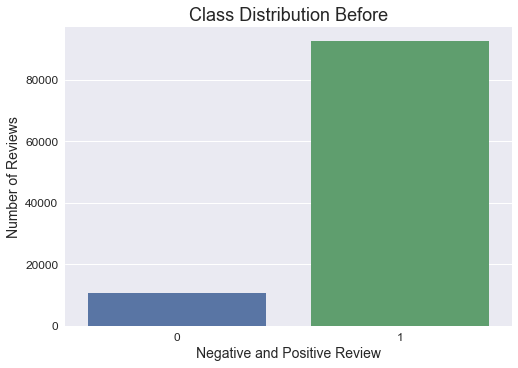

In [55]:
# Plot class distribution using PySpark before addressing class imbalance
class_distribution_before = df.groupBy('Score').count().toPandas()

plt.style.use('seaborn')
sns.barplot(data=class_distribution_before, x='Score', y='count')
plt.title('Class Distribution Before', fontsize=18)
plt.xlabel('Negative and Positive Review', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [56]:
# Balance the class distribution by sampling the positive class
df_class_0 = df.filter(df['Score'] == 0)
df_class_1 = df.filter(df['Score'] == 1).sample(False, 0.12)  # Adjust the sampling ratio here
df = df_class_0.union(df_class_1)

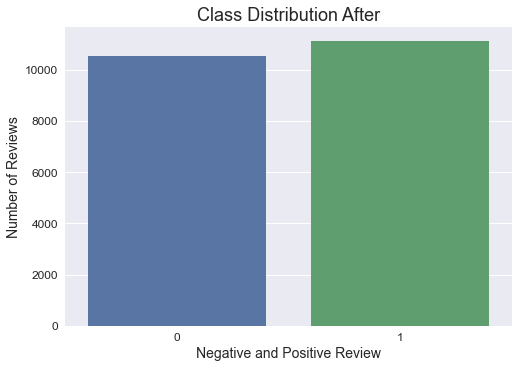

In [57]:
# Plot class distribution using PySpark
class_distribution = df.groupBy('Score').count().toPandas()

plt.style.use('seaborn')
sns.barplot(data=class_distribution, x='Score', y='count')
plt.title('Class Distribution After', fontsize=18)
plt.xlabel('Negative and Positive Review', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [58]:
# Define function for spell checking using TextBlob
def spell_check(text):
    blob = TextBlob(text)
    return str(blob.correct())


In [59]:
# Apply spell checking function
spell_check_udf = udf(spell_check, StringType())
df = df.withColumn('Reviews_Clean_Spell_Checked', spell_check_udf('Reviews_Clean'))


In [61]:
# Save spell-checked DataFrame to CSV
df.select('Hotel_Name', 'Negative_Review', 'Positive_Review', 'Reviewer_Score', 'Reviews_Clean', 'Spell_Checked', 'Score').write.csv("C:/Users/Utkarsh Srivastava/Downloads/BIG DATA/pyspark/spell_checked.csv", header=True)

In [62]:
# Tokenize text
tokenizer = Tokenizer(inputCol='Reviews_Clean_Spell_Checked', outputCol='tokens')
df_tokenized = tokenizer.transform(df)


In [64]:
# Save preprocessed DataFrame to CSV
df_tokenized.select('Hotel_Name', 'Negative_Review', 'Positive_Review', 'Reviewer_Score', 'Reviews_Clean_Spell_Checked', 'Score').write.csv("C:/Users/Utkarsh Srivastava/Downloads/BIG DATA/pyspark/no_class_imbalance.csv", header=True)


In [65]:
# Stop SparkSession
spark.stop()